In [13]:
from typing import List

import pandas as pd
import numpy as np
import torch
from transformers import (
                        DistilBertTokenizer,
                        DistilBertForSequenceClassification,
                        get_scheduler,
                        )
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
                            accuracy_score,
                            precision_score,
                            recall_score,
                            multilabel_confusion_matrix,
                            ConfusionMatrixDisplay
                            )
from sklearn.utils import resample

## Configuration for training parameters

In [32]:
value_max_length = 128
value_test_size = 0.20
v_batch_size = 16
value_learning_rate = 2e-5
epochs = 3

output_dir = "saved_distilbert_model_08_bs_16_lr_2_ep_3_ac_9263_"

## Load data

In [15]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_labels_df = pd.read_csv("test_labels.csv")

## Data Preparation

In [16]:
labels_columns = [
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate"]
train_labels = train_df[labels_columns]

X = train_df["comment_text"]

In [17]:
max_class_count = train_df[labels_columns].sum(axis=0).max()

augmented_dataframes = []

15294

In [18]:
# Augmentation of single classes
for label in labels_columns:
    single_class_data = train_df[(train_df[label] == 1) &
                                  (train_df[labels_columns].sum(axis=1) == 1)]
    
    if single_class_data.empty:
        print(f"No single-class data available for label: {label}")
        single_class_data = train_df[train_df[label] == 1]

    oversampled_class = resample(
                                single_class_data,
                                replace=True,
                                n_samples=max_class_count,
                                random_state=42
                                )
    augmented_dataframes.append(oversampled_class)

No single-class data available for label: severe_toxic


In [19]:
# Addition of mixed classes
train_toxic_mixed_classes = train_df[train_df[labels_columns].sum(axis=1) > 1]
augmented_dataframes.append(train_toxic_mixed_classes)

In [20]:
# Combining all DataFrames
augmented_dataframes = pd.concat(augmented_dataframes, ignore_index=True)

# Checking the result
print("Shape of augmented DataFrame:", augmented_dataframes.shape)
print("Class distribution after augmentation:")
print(augmented_dataframes[labels_columns].sum())

Shape of augmented DataFrame: (101629, 8)
Class distribution after augmentation:
toxic            40216
severe_toxic     16889
obscene          38009
threat           16829
insult           36080
identity_hate    19744
dtype: int64


## Split into training and validation sets

In [21]:
# Calculating the sum of labels for each row
train_labels_sum = train_labels.sum(axis=1)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(
                                                X,
                                                train_labels,
                                                test_size=value_test_size,
                                                random_state=42,
                                                stratify=train_labels_sum
                                                )

## Tokenizer configuration

In [24]:
def tokenize_data(
                  texts: List[str],
                  labels: List[int],
                  tokenizer,
                  max_len: int = value_max_length
                 ) -> TensorDataset:
    """
    Tokenizes the input texts and converts them into input tensors, along with
    corresponding attention masks. Also prepares the label tensor for model
    training.

    Parameters:
    - texts (List[str]): List of text strings to be tokenized.
    - labels (List[int]): List of labels corresponding to the texts.
    - tokenizer: The tokenizer (e.g., from HuggingFace's Transformers library)
         used for tokenization.
    - max_len (int, optional): Maximum length of the tokenized sequence. 
         Default is `value_max_length`.

    Returns:
    - TensorDataset: A PyTorch `TensorDataset` containing input_ids,
         attention_masks, and label_tensors.
    """
    input_ids, attention_masks = [], []

    # Iterate through each text and tokenize it
    for text in texts:
        encoding = tokenizer.encode_plus(
                             text,
                             add_special_tokens=True,
                             max_length=max_len,
                             truncation=True,
                             pad_to_max_length=True,
                             return_attention_mask=True,
                             return_tensors="pt"
                             )
        
        input_ids.append(encoding["input_ids"])
        attention_masks.append(encoding["attention_mask"])

    # Combine all input_ids and attention_masks into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Ensure labels are converted to a PyTorch tensor
    if not isinstance(labels, torch.Tensor):
        label_tensors = torch.tensor(labels, dtype=torch.float32)

    return TensorDataset(input_ids, attention_masks, label_tensors)

In [25]:
# tokenization of data
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=True)

train_dataset = tokenize_data(X_train, y_train.values, tokenizer=tokenizer)
val_dataset = tokenize_data(X_val, y_val.values, tokenizer=tokenizer)

#Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=v_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=v_batch_size, shuffle=False)


c:\Python_Env\Torch_env\Lib\site-packages\transformers\tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Create model

In [26]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using devise: {device}")

# Load pre-trained DistilBERT model for sequence classification with 6 labels
model = DistilBertForSequenceClassification.from_pretrained(
                                            "distilbert-base-uncased",
                                            num_labels=6
                                            )
# Move model to the selected device (GPU or CPU)
model.to(device)

Using devise: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [27]:
# Define BCE loss function for binary classification with logits
loss_fn = torch.nn.BCEWithLogitsLoss()

# Initialize AdamW optimizer with model parameters and learning rate
optimizer = AdamW(model.parameters(), lr=value_learning_rate)

# Set up linear scheduler to adjust learning rate during training
num_training_steps = epochs * len(train_loader)
scheduler = get_scheduler(
                          "linear",
                          optimizer=optimizer,
                          num_warmup_steps=0,
                          num_training_steps=num_training_steps,
                          )

## Model training

In [28]:
def train_model(
                model: torch.nn.Module,
                train_loader: DataLoader,
                optimizer: AdamW,
                scheduler,
                loss_fn:  torch.nn.BCEWithLogitsLoss,
                device: torch.device,
                epochs: int = epochs
                ) -> None:
    """
    Trains the model on the provided training data using the specified
    optimizer, scheduler, and loss function. This function performs the
    training for a specified number of epochs and prints the loss after each
    epoch.

    Parameters:
    - model: The model to be trained.
    - train_loader: The DataLoader providing batches of training data.
    - optimizer: The optimizer used for model parameter updates.
    - scheduler: The learning rate scheduler to adjust the learning rate
        during training.
    - loss_fn: The loss function used to compute the loss during training.
    - device: The device on which the model and data should be loaded.
    - epochs (int, optional): The number of training epochs.

    Returns:
    - None: This function doesn't return anything, it prints the loss during
        training.
    """
    model.train()

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Using device: {device}")

        # Iterate over batches of data from the DataLoader
        for batch in train_loader:
            optimizer.zero_grad()

            # Move data to the correct device (CPU or GPU)
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].float().to(device)   

            # Forward pass: predict logits
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Compute loss using the provided loss function
            loss = loss_fn(logits, labels)
            
            # Backward pass: compute gradients and update parameters
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Print the loss after each epoch
        print(f"Loss after epoch {epoch + 1}: {loss.item():.4f}")


In [29]:

# Call the function to train the model
train_model(model, train_loader, optimizer, scheduler, loss_fn, device, epochs)

Epoch 1/3
Using devise: cuda
Loss: 0.0017
Epoch 2/3
Using devise: cuda
Loss: 0.0087
Epoch 3/3
Using devise: cuda
Loss: 0.0457


## Evaluation of the model on validation data

Accuracy: 0.9263
Precision: 0.7911
Recall: 0.7833
Confusion Matrices for Each Class:
Class 0:
[[28281   564]
 [  520  2550]]
Class 1:
[[31506    79]
 [  211   119]]
Class 2:
[[29943   284]
 [  249  1439]]
Class 3:
[[31790    21]
 [   62    42]]
Class 4:
[[29955   406]
 [  354  1200]]
Class 5:
[[31544    98]
 [  125   148]]


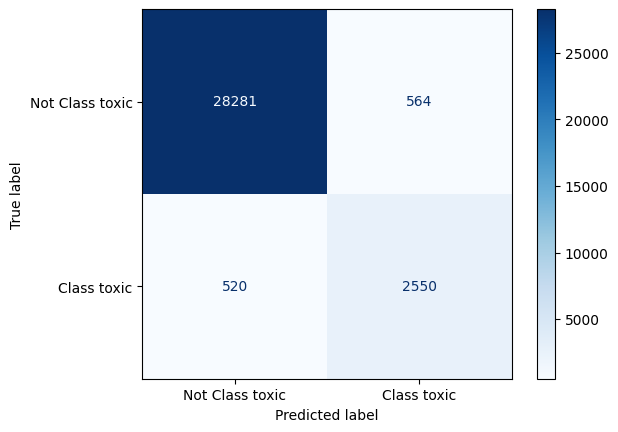

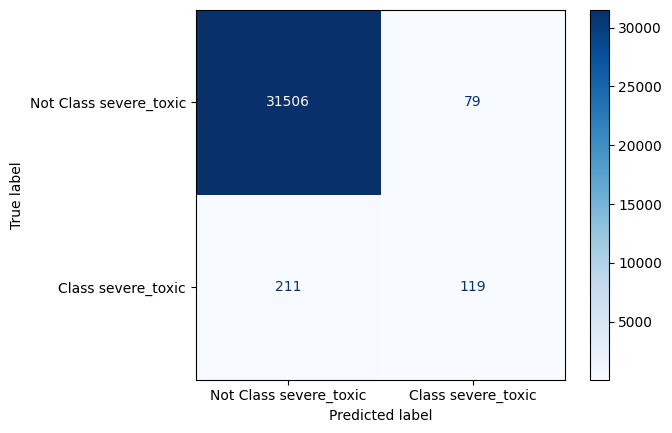

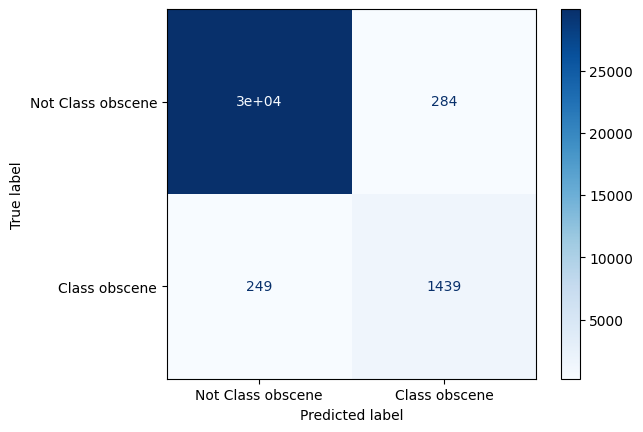

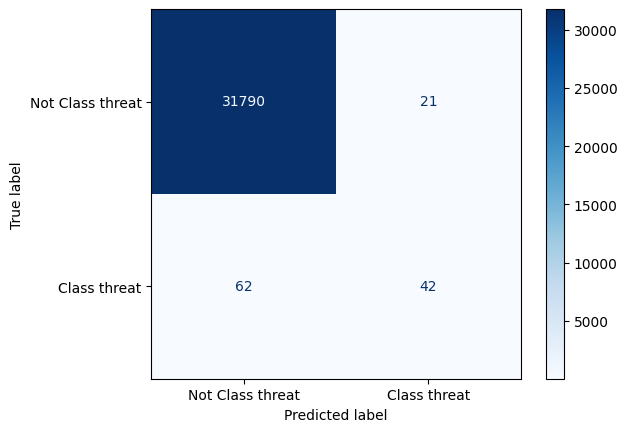

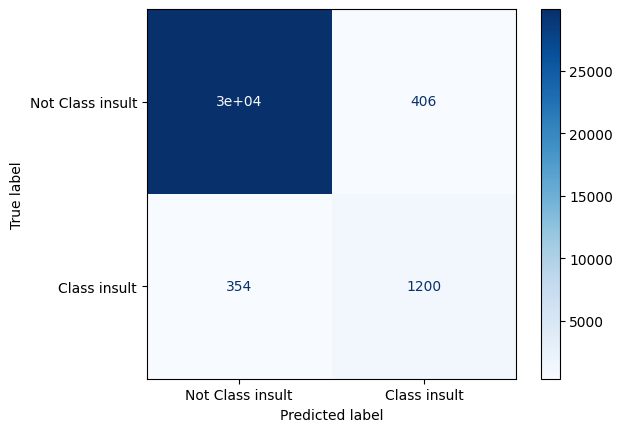

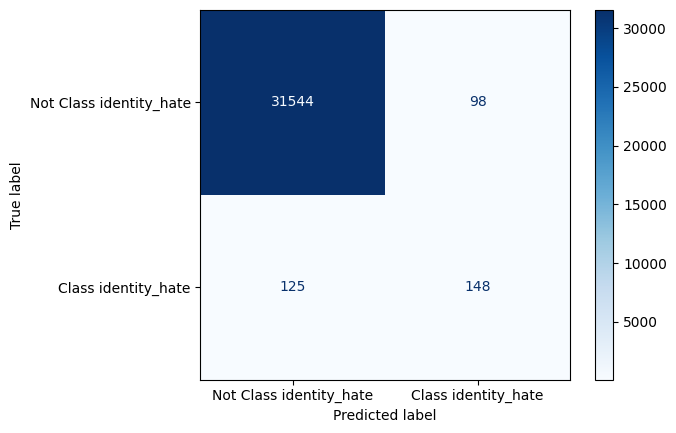

In [30]:
def evaluate_model(
                   model: torch.nn.Module, 
                   val_loader: DataLoader, 
                   device: torch.device
                   ) -> None:
    """
    Evaluates the model on the provided validation data and calculates various
    evaluation metrics including accuracy, precision, recall, and confusion
    matrices for each class.

    Parameters:
    - model (torch.nn.Module): The model to be evaluated.
    - val_loader (DataLoader): A DataLoader object that provides batches of
        validation data, each containing input tensors.
    - device (torch.device): The device to which the model and data should be
        moved (e.g., 'cuda' or 'cpu').

    Returns:
    - None: This function does not return anything, but prints the evaluation
      metrics and confusion matrices.
    """
    model.eval()

    true_labels = [] 
    predicted_probs = [] 

    with torch.no_grad(): 
        for batch in val_loader: 
            input_ids, attention_mask, labels = [t.to(device) for t in batch] 

            # Get model's predictions 
            outputs = model(input_ids, attention_mask=attention_mask) 
            # Use sigmoid for multilabel classification 
            predicted_probs_batch = torch.sigmoid(outputs.logits) 
            predicted_probs.append(predicted_probs_batch.cpu().numpy()) 

            true_labels_batch = labels.cpu().numpy() 
            true_labels.append(true_labels_batch) 

    # Combine predictions and labels for evaluation 
    true_labels = np.concatenate(true_labels, axis=0) 
    predicted_probs = np.concatenate(predicted_probs, axis=0) 
    predicted_labels = (predicted_probs > 0.5).astype(int)

    # Calculate evaluation metrics 
    accuracy = accuracy_score(true_labels, predicted_labels) 
    precision = precision_score(true_labels, predicted_labels, average='micro') 
    recall = recall_score(true_labels, predicted_labels, average='micro')
    conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels)

    # Print the evaluation metrics 
    print(f'Accuracy: {accuracy:.4f}') 
    print(f'Precision: {precision:.4f}') 
    print(f'Recall: {recall:.4f}')
    print(f'Confusion Matrices for Each Class:')
    for i, matrix in enumerate(conf_matrix):
        print(f"Class {i}:\n{matrix}")

    # Display confusion matrices for each class
    for i, matrix in enumerate(conf_matrix):
        disp = ConfusionMatrixDisplay(
            confusion_matrix=matrix,
            display_labels=[
                            f'Not Class {labels_columns[i]}',
                            f'Class {labels_columns[i]}'
                            ]
            )
        disp.plot(cmap='Blues')

# Call the function to evaluate the model on the test data 
evaluate_model(model, val_loader, device)

## Save model

In [33]:
model.save_pretrained(output_dir)

tokenizer.save_pretrained(output_dir)

('saved_distilbert_model_08_bs_16_lr_2_ep_3_ac_9263_\\tokenizer_config.json',
 'saved_distilbert_model_08_bs_16_lr_2_ep_3_ac_9263_\\special_tokens_map.json',
 'saved_distilbert_model_08_bs_16_lr_2_ep_3_ac_9263_\\vocab.txt',
 'saved_distilbert_model_08_bs_16_lr_2_ep_3_ac_9263_\\added_tokens.json')